<a href="https://colab.research.google.com/github/Suijith/NBA-GAME-PREDICTOR/blob/main/NBA_GAME_PREDICTOR_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA GAME PREDICTOR

## Install NBA API

In [1]:
pip install nba_api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 2.6 MB/s eta 0:00:00



## Collect Data

In [2]:
from nba_api.stats.static import teams
team_games = {}
nba_teams = teams.get_teams()
for i in range(len(nba_teams)):
  team_info = nba_teams[i]
  team_games[team_info['id']] = None

In [ ]:
team_games.keys()

dict_keys([1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

I decided to take the past three seasons and no more past that because I would then have to include the 2019-2020 season, where part of the NBA games played were in the bubble in Orlando.

In [3]:
from nba_api.stats.endpoints import leaguegamefinder
for team_id in team_games:
  gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
  games = gamefinder.get_data_frames()[0]
  team_games[team_id] = games[games.SEASON_ID.str[-4:].isin(['2020', '2021', '2022', '2023'])][['SEASON_ID', 'TEAM_NAME', 'GAME_DATE', 'MATCHUP', 'WL', 'FG_PCT', 'FT_PCT', 'REB', 'TOV', 'PF', 'PLUS_MINUS']]
  team_games[team_id]['MATCHUP'] = team_games[team_id]['MATCHUP'].astype(str).apply(lambda x: x[-3:])
  team_games[team_id].rename(columns={'MATCHUP': 'OPP'}, inplace=True)
  team_games[team_id] = team_games[team_id].dropna(subset=['WL'])
  team_games[team_id]['WL'] = team_games[team_id]['WL'].replace({'W': 1, 'L': 0})


In [ ]:
team_games[1610612755]

,SEASON_ID,TEAM_NAME,GAME_DATE,OPP,WL,FG_PCT,FT_PCT,REB,TOV,PF,PLUS_MINUS
1,22023,Philadelphia 76ers,2024-01-16,DEN,1,0.566,0.735,32,8,21,5.0
2,22023,Philadelphia 76ers,2024-01-15,HOU,1,0.482,0.853,41,10,24,9.0
3,22023,Philadelphia 76ers,2024-01-12,SAC,1,0.430,0.944,46,13,19,19.0
4,22023,Philadelphia 76ers,2024-01-10,ATL,0,0.451,0.848,51,11,28,-7.0
5,22023,Philadelphia 76ers,2024-01-06,UTA,0,0.404,0.783,34,6,20,-11.0
...,...,...,...,...,...,...,...,...,...,...,...
341,22020,Philadelphia 76ers,2020-12-27,CLE,0,0.418,0.727,39,21,19,-24.0
342,22020,Philadelphia 76ers,2020-12-26,NYK,1,0.466,0.727,47,12,19,20.0
343,22020,Philadelphia 76ers,2020-12-23,WAS,1,0.471,0.767,47,16,25,6.0
344,12020,Philadelphia 76ers,2020-12-18,IND,1,0.533,0.629,48,26,31,6.0


## Data Pre-Processing

In [4]:
df = team_games[1610612763]
X = df[['FG_PCT', 'FT_PCT', 'REB', 'TOV', 'PF']].values
y = df['WL'].values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## BUILDING PREDICTION MODELS AND TESTING ACCURACY

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  64
Number of incorrect predictions:  6
Accuracy Score:  0.9142857142857143


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 74.99 %
Standard Deviation: 6.78 %


### K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 1, weights = 'distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  57
Number of incorrect predictions:  13
Accuracy Score:  0.8142857142857143


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 73.19 %
Standard Deviation: 6.36 %


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validated Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Best Cross-validated Accuracy: 0.757012987012987


### Kernel Support Vector Machine

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', C = 1, gamma = 0.2, random_state = 42)
classifier.fit(X_train, y_train)

SVC(C=1, gamma=0.2, random_state=42)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  62
Number of incorrect predictions:  8
Accuracy Score:  0.8857142857142857


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 74.66 %
Standard Deviation: 9.40 %


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 77.17 %
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state = 42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  61
Number of incorrect predictions:  9
Accuracy Score:  0.8714285714285714


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 73.13 %
Standard Deviation: 10.04 %


In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", accuracy)

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test set accuracy: 0.7571428571428571


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50, bootstrap = True, min_samples_split = 5, criterion = 'gini', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  56
Number of incorrect predictions:  14
Accuracy Score:  0.8


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 77.54 %
Standard Deviation: 6.84 %


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", accuracy)

Best hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Test set accuracy: 0.8428571428571429


## Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
nbClassifier = GaussianNB()
nbClassifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = nbClassifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  58
Number of incorrect predictions:  12
Accuracy Score:  0.8285714285714286


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = nbClassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 77.55 %
Standard Deviation: 6.93 %


### XGBoost

In [ ]:
from xgboost import XGBClassifier
xgClassifier = XGBClassifier()
xgClassifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgClassifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print("Number of correct predictions: ", (cm[0][0] + cm[1][1]))
print("Number of incorrect predictions: ", (cm[0][1] + cm[1][0]))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Number of correct predictions:  59
Number of incorrect predictions:  11
Accuracy Score:  0.8428571428571429


In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgClassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 73.94 %
Standard Deviation: 7.09 %


#### The Naive Bayes Model seems to have the best overall accuracy, however the random forest classifier also seems to be a great model as well

## LETS SEE HOW MANY CORRECT PREDICTIONS WE CAN MAKE IN NBA GAMES

### 1/20/24

In [ ]:
import numpy as np
matchups = [[1610612749,1610612765],[1610612755, 1610612766], [1610612759, 1610612764], [1610612761, 1610612752], [1610612739,1610612737], [1610612762,1610612745], [1610612763,1610612741],[1610612760,1610612750]
]
print("PREDICTIONS (01/20/24)\n-------------------------------------------------------------")
for matchup in matchups:
  winning_chance = []
  for team_id in matchup:
    df = team_games[team_id]
    data = df.head(7)[['FG_PCT', 'FT_PCT', 'REB', 'TOV', 'PF']].values
    mean_of_columns = np.mean(data, axis=0)
    last5Games = np.array([mean_of_columns])
    scaledStats = sc.transform(last5Games)
    prob = nbClassifier.predict_proba(scaledStats)
    winning_chance.append(prob[0][1])
  print('Matchup: %s VS %s'%( team_games[matchup[0]].iloc[0,1], team_games[matchup[1]].iloc[0,1]))
  if winning_chance[0] > winning_chance[1]:

    print('Predicted Winner: %s\n'%(team_games[matchup[0]].iloc[0,1]))
  else:
    print('Predicted Winner: %s\n'%(team_games[matchup[1]].iloc[0,1]))

PREDICTIONS (01/20/24)
-------------------------------------------------------------
Matchup: Milwaukee Bucks VS Detroit Pistons
Predicted Winner: Milwaukee Bucks

Matchup: Philadelphia 76ers VS Charlotte Hornets
Predicted Winner: Philadelphia 76ers

Matchup: San Antonio Spurs VS Washington Wizards
Predicted Winner: San Antonio Spurs

Matchup: Toronto Raptors VS New York Knicks
Predicted Winner: Toronto Raptors

Matchup: Cleveland Cavaliers VS Atlanta Hawks
Predicted Winner: Cleveland Cavaliers

Matchup: Utah Jazz VS Houston Rockets
Predicted Winner: Utah Jazz

Matchup: Memphis Grizzlies VS Chicago Bulls
Predicted Winner: Chicago Bulls

Matchup: Oklahoma City Thunder VS Minnesota Timberwolves
Predicted Winner: Oklahoma City Thunder



### ACTUAL RESULTS

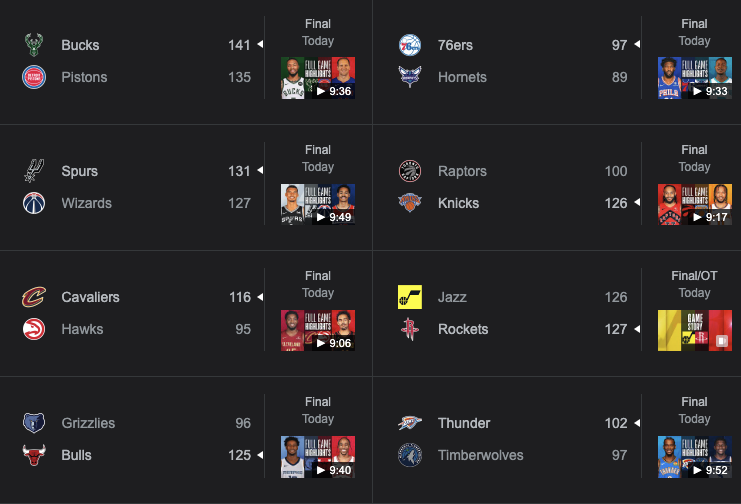

### 1/21/24

In [ ]:
import numpy as np
matchups = [[1610612751,1610612746],[1610612743, 1610612764], [1610612748, 1610612753], [1610612738, 1610612745], [1610612754,1610612756], [1610612757,1610612747]]
print("PREDICTIONS (01/21/24)\n-------------------------------------------------------------")
for matchup in matchups:
  winning_chance = []
  for team_id in matchup:
    df = team_games[team_id]
    data = df.head(7)[['FG_PCT', 'FT_PCT', 'REB', 'TOV', 'PF']].values
    mean_of_columns = np.mean(data, axis=0)
    last5Games = np.array([mean_of_columns])
    scaledStats = sc.transform(last5Games)
    prob = nbClassifier.predict_proba(scaledStats)
    winning_chance.append(prob[0][1])
  print('Matchup: %s VS %s'%( team_games[matchup[0]].iloc[0,1], team_games[matchup[1]].iloc[0,1]))
  print(winning_chance)
  if winning_chance[0] > winning_chance[1]:

    print('Predicted Winner: %s\n'%(team_games[matchup[0]].iloc[0,1]))
  else:
    print('Predicted Winner: %s\n'%(team_games[matchup[1]].iloc[0,1]))

PREDICTIONS (01/21/24)
-------------------------------------------------------------
Matchup: Brooklyn Nets VS LA Clippers
[0.5629605682192483, 0.807107149318405]
Predicted Winner: LA Clippers

Matchup: Denver Nuggets VS Washington Wizards
[0.9334334825105135, 0.628010678985148]
Predicted Winner: Denver Nuggets

Matchup: Miami Heat VS Orlando Magic
[0.5618180513446168, 0.47584112968290987]
Predicted Winner: Miami Heat

Matchup: Boston Celtics VS Houston Rockets
[0.6080668100737452, 0.5948353171044023]
Predicted Winner: Boston Celtics

Matchup: Indiana Pacers VS Phoenix Suns
[0.6658998709898359, 0.8441901715265002]
Predicted Winner: Phoenix Suns

Matchup: Portland Trail Blazers VS Los Angeles Lakers
[0.33067807627433443, 0.8097894516335608]
Predicted Winner: Los Angeles Lakers



### ACTUAL RESULTS

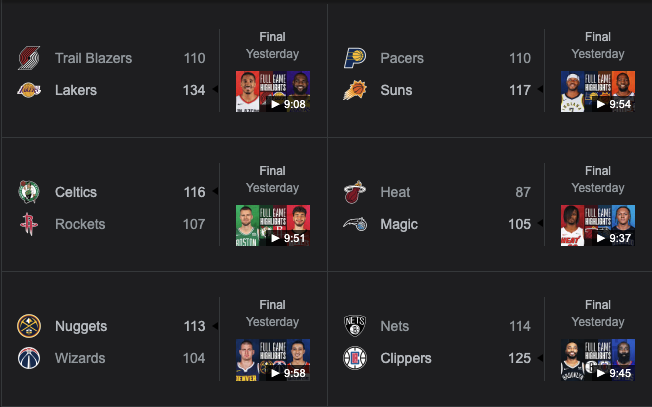

### 1/22/24

In [12]:
import numpy as np
matchups = [[1610612739,1610612753],[1610612759, 1610612755], [1610612749, 1610612765], [1610612763, 1610612761], [1610612766,1610612750], [1610612738,1610612742], [1610612741,1610612756],[1610612737,1610612758]]
print("PREDICTIONS (01/22/24)\n-------------------------------------------------------------")
for matchup in matchups:
  winning_chance = []
  for team_id in matchup:
    df = team_games[team_id]
    data = df.head(7)[['FG_PCT', 'FT_PCT', 'REB', 'TOV', 'PF']].values
    mean_of_columns = np.mean(data, axis=0)
    last5Games = np.array([mean_of_columns])
    scaledStats = sc.transform(last5Games)
    prob = nbClassifier.predict_proba(scaledStats)
    winning_chance.append(prob[0][1])
  print('Matchup: %s VS %s'%( team_games[matchup[0]].iloc[0,1], team_games[matchup[1]].iloc[0,1]))
  if winning_chance[0] > winning_chance[1]:

    print('Predicted Winner: %s\n'%(team_games[matchup[0]].iloc[0,1]))
  else:
    print('Predicted Winner: %s\n'%(team_games[matchup[1]].iloc[0,1]))

PREDICTIONS (01/22/24)
-------------------------------------------------------------
Matchup: Cleveland Cavaliers VS Orlando Magic
Predicted Winner: Cleveland Cavaliers

Matchup: San Antonio Spurs VS Philadelphia 76ers
Predicted Winner: San Antonio Spurs

Matchup: Milwaukee Bucks VS Detroit Pistons
Predicted Winner: Milwaukee Bucks

Matchup: Memphis Grizzlies VS Toronto Raptors
Predicted Winner: Toronto Raptors

Matchup: Charlotte Hornets VS Minnesota Timberwolves
Predicted Winner: Minnesota Timberwolves

Matchup: Boston Celtics VS Dallas Mavericks
Predicted Winner: Boston Celtics

Matchup: Chicago Bulls VS Phoenix Suns
Predicted Winner: Phoenix Suns

Matchup: Atlanta Hawks VS Sacramento Kings
Predicted Winner: Sacramento Kings



In [ ]:
for team_id in team_games:
  print(team_id)
  display(team_games[team_id]['TEAM_NAME'][0])

1610612737


'Atlanta Hawks'

1610612738


'Boston Celtics'

1610612739


'Cleveland Cavaliers'

1610612740


'New Orleans Pelicans'

1610612741


'Chicago Bulls'

1610612742


'Dallas Mavericks'

1610612743


'Denver Nuggets'

1610612744


'Golden State Warriors'

1610612745


'Houston Rockets'

1610612746


'LA Clippers'

1610612747


'Los Angeles Lakers'

1610612748


'Miami Heat'

1610612749


'Milwaukee Bucks'

1610612750


'Minnesota Timberwolves'

1610612751


'Brooklyn Nets'

1610612752


'New York Knicks'

1610612753


'Orlando Magic'

1610612754


'Indiana Pacers'

1610612755


'Philadelphia 76ers'

1610612756


'Phoenix Suns'

1610612757


'Portland Trail Blazers'

1610612758


'Sacramento Kings'

1610612759


'San Antonio Spurs'

1610612760


'Oklahoma City Thunder'

1610612761


'Toronto Raptors'

1610612762


'Utah Jazz'

1610612763


'Memphis Grizzlies'

1610612764


'Washington Wizards'

1610612765


'Detroit Pistons'

1610612766


'Charlotte Hornets'